# Compositional analysis

Beyond changes in gene expression patterns, cell compositions, such as the proportions of cell-types, can change between conditions. A specific drug may, for example, induce a transdifferentiation of a cell type which will be reflected in the cell identity composition. Sufficient cell and sample numbers are required to accurately determine cell-identity cluster proportions and background variation. Compositional analysis can be done on the level of cell identity clusters in the form of known cell types or cell states corresponding to, for example, cells recently affected by perturbations.


<img alt="AnnData Overview" src="../_static/images/anndata_schema.jpg" width="800px"/>

AnnData overview. Image obtained from {cite}`Virshup2021`.



This chapter will introduce both approaches and apply them to the Haber dataset{cite}`Haber2017`. This dataset contains 53,193 individual epithelial cells from the small intestine and organoids of mice. Some of the cells were also subject to bacterial or helminth infection such as through Salmonella and Heligmosomoides polygyrus respectively.
Throughout this tutorial we are using a subset of the complete Haber dataset which only includes control and infected cells that were collected specifically for this purpose. Notably, we are excluding an additional dataset which collected only large cells for faster computation and reduced complexity.

As a first step, we load the dataset.

## Data loading

In [1]:
import importlib
import warnings

import pandas as pd

warnings.filterwarnings("ignore")

import scanpy as sc
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

In [2]:
adata = sc.read("haber_count.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 9842 × 15215
    obs: 'batch', 'barcode', 'condition', 'cell_label'

In [4]:
adata.obs

,batch,barcode,condition,cell_label
index,,,,
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor,B1,AAACATACCACAAC,Control,Enterocyte.Progenitor
B1_AAACGCACGAGGAC_Control_Stem,B1,AAACGCACGAGGAC,Control,Stem
B1_AAACGCACTAGCCA_Control_Stem,B1,AAACGCACTAGCCA,Control,Stem
B1_AAACGCACTGTCCC_Control_Stem,B1,AAACGCACTGTCCC,Control,Stem
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor,B1,AAACTTGACCACCT,Control,Enterocyte.Progenitor
...,...,...,...,...
B10_TTTCACGACAAGCT_Salmonella_TA,B10,TTTCACGACAAGCT,Salmonella,TA
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte,B10,TTTCAGTGAGGCGA,Salmonella,Enterocyte
B10_TTTCAGTGCGACAT_Salmonella_Stem,B10,TTTCAGTGCGACAT,Salmonella,Stem


The data was collected in 10 batches. Unique conditions are Control, Salmonella, Hpoly.Day3 and Hpoly.Day10 which correspond to the healthy control state, Salmonella infection, Heligmosomoides polygyrus infected cells after 3 days and Heligmosomoides polygyrus infected cells after 10 days. The `cell_label` corresponds to the cell types.

## Why cell-type count data is compositional

When analyzing the compositional shifts in cell count data, multiple technical and methodological limitations need to be accounted for. One challenge is the characteristically low number of experimental replicates, which leads to large confidence intervals when conducting differential abundance analysis with frequentist statistical tests.
Even more important, single-cell sequencing is naturally limited in the number of cells per sample - we can't sequence every cell in a tissue or organ, but use a small, representative snapshot instead. This, however, forces us to view the cell type counts as purely proportional, i.e. the total number of cells in a sample is only a scaling factor. In the statistical literature, such data is known as compositional data{cite}`Aitchison1982`, and characterized by the relative abundances of all features (cell types in our case) in one sample always adding up to one.

Because of this sum-to-one constraint, a negative correlation between the cell types is induced. To illustrate this, let's consider the following example:

In a case-control study, we want to compare the cell type composition of a healthy and a diseased organ. In both cases, we have three cell types (A, B and C), but their abundances differ:
- The healthy organ consists of 2,000 cells of each type (6,000 cells total).
- The disease leads to a doubling of cell type A, while cell types B and C are not affected, so that the diseased organ has 8,000 cells.

In [5]:
healthy_tissue = [2000, 2000, 2000]
diseased_tissue = [4000, 2000, 2000]
example_data_global = pd.DataFrame(data=np.array([healthy_tissue, diseased_tissue]), index=[1,2], columns=["A", "B", "C"])
example_data_global["Disease status"] = ["Healthy", "Diseased"]
example_data_global

,A,B,C,Disease status
1,2000,2000,2000,Healthy
2,4000,2000,2000,Diseased


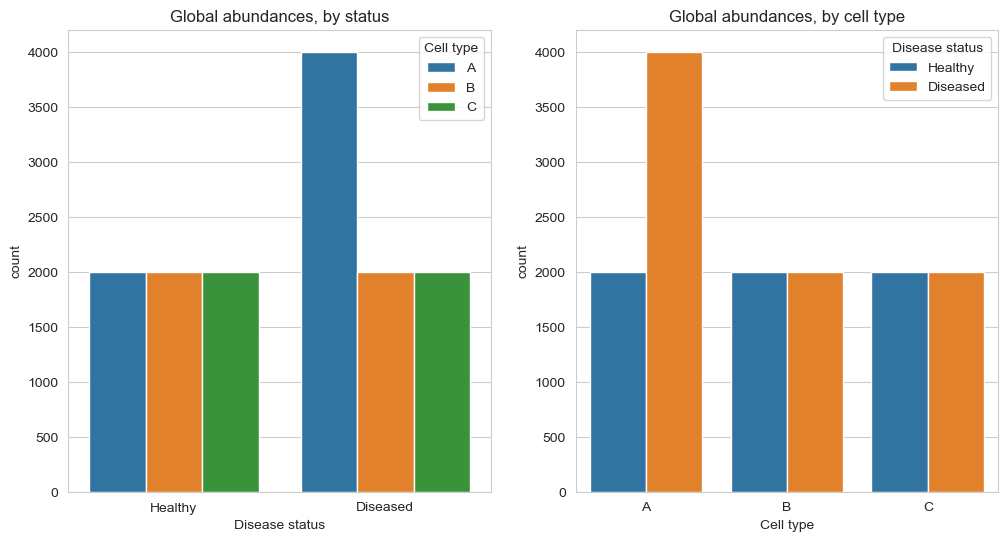

In [6]:
plot_data_global = example_data_global.melt("Disease status", ["A", "B", "C"], "Cell type", "count")

fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.barplot(data=plot_data_global, x="Disease status", y="count", hue="Cell type", ax=ax[0])
ax[0].set_title("Global abundances, by status")

sns.barplot(data=plot_data_global, x="Cell type", y="count", hue="Disease status", ax=ax[1])
ax[1].set_title("Global abundances, by cell type")

plt.show()


We want to find out which cell types increase or decrease in abundance in the diseased organ. If we are able to determine the type of every cell in both organs, the case would be clear, as we can see in the right plot above. Unfortunately, this is not possible. Since our sequencing process has a limited capacity, we can only take a representative sample of 600 cells from both populations. To simulate this step, we can use numpy's `random.multinomial` function to sample 600 cells from the populations without replacement:

In [7]:
np.random.seed(1234)
healthy_sample = np.random.multinomial(pvals=healthy_tissue/np.sum(healthy_tissue), n=600)
diseased_sample = np.random.multinomial(pvals=diseased_tissue/np.sum(diseased_tissue), n=600)
example_data_sample = pd.DataFrame(data=np.array([healthy_sample, diseased_sample]), index=[1,2], columns=["A", "B", "C"])
example_data_sample["Disease status"] = ["Healthy", "Diseased"]
example_data_sample

,A,B,C,Disease status
1,193,201,206,Healthy
2,296,146,158,Diseased


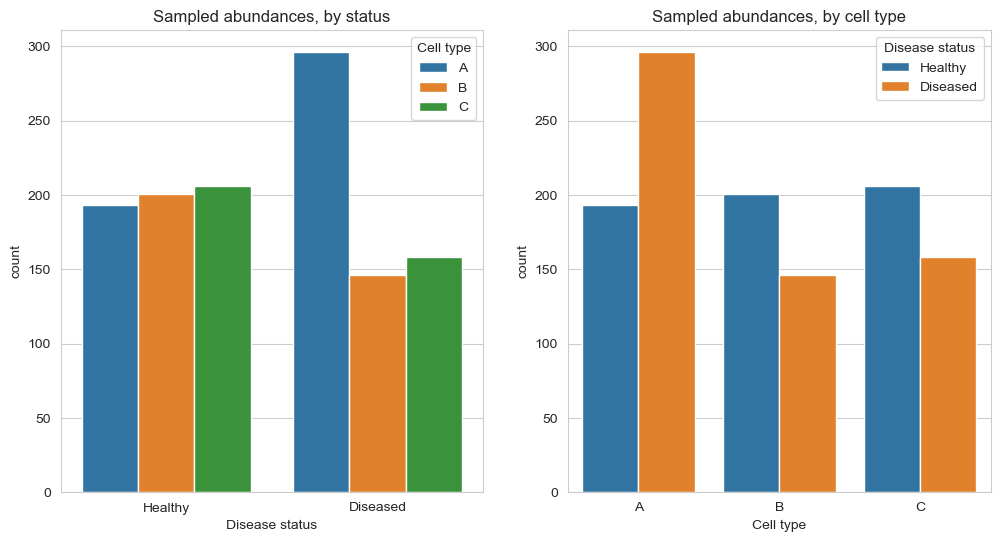

In [8]:
plot_data_sample = example_data_sample.melt("Disease status", ["A", "B", "C"], "Cell type", "count")

fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.barplot(data=plot_data_sample, x="Disease status", y="count", hue="Cell type", ax=ax[0])
ax[0].set_title("Sampled abundances, by status")

sns.barplot(data=plot_data_sample, x="Cell type", y="count", hue="Disease status", ax=ax[1])
ax[1].set_title("Sampled abundances, by cell type")
plt.show()

Now the picture is not clear anymore. While the counts of cell type A still increase (approx. from 200 to 300), the other two cell types seem to decrease from about 200 to 150. This apparent decrease is caused by our constraint to 600 cells - If a larger fraction of the sample is taken up by cell type A, the share of cell types B and C must be lower. Therefore, determining the change in abundance of one cell type is impossible without taking the other cell types into account.

If we ignore the compositionality of the data, and use univariate methods like Wilcoxon rank-sum tests or scDC, a method which performs differential cell-type composition analysis by bootstrap resampling{cite}Cao2019, we may falsely perceive cell-type population shifts as statistically sound effects, although they were induced by inherent negative correlations of the cell-type proportions.

Furthermore, the subsampled data does not only give us one valid solution to our question. If both cell types B and C decreased by 1,000 cells in the diseased case, we would obtain the same representative samples of 600 cells as above. To get a unique result, we can fix a reference point for the data, which is assumed to be unchanged throughout all samples{cite}Brill2019. This can be a single cell type, an aggregation over multiple cell types such as the geometric mean, or a set of orthogonal bases{cite}Egozcue2003.

While single-cell datasets of sufficient size and replicate number have only been around for a few years, the same statistical property has also been discussed in the context of microbial analysis{cite}Gloor2017. There, some popular approaches include ANCOM-BC {cite}Lin2021 and ALDEx2 {cite}Fernandes2014. However, these approaches often struggle with single-cell datasets due to the small number of experimental replicates.

This issue has been tackled by scCODA{cite}Büttner2021, which we are going to introduce and apply to our dataset in the following section.

## With labeled clusters

[scCODA](https://sccoda.readthedocs.io/en/latest/) belongs to the family of tools that require pre-defined clusters, most commony cell types, to statistically derive changes in composition. Inspired by methods for compositional analysis of microbiome data, scCODA proposes a Bayesian approach to address the low replicate issue as commonly encountered in single-cell analysis{cite}`Büttner2021`. It models cell-type counts using a hierarchical Dirichlet-Multinomial model, which accounts for uncertainty in cell-type proportions and the negative correlative bias via joint modeling of all measured cell-type proportions. To ensure a uniquely identifiable solution and easy interpretability, the reference in scCODA is chosen to be a specific cell type. Hence, any detected compositional changes by scCODA always have to be viewed in relation to the selected reference.

However, scCODA assumes a log-linear relationship between covariates and cell abundance, which may not always reflect the underlying biological processes when using continuoaus covariates. A further limitation of scCODA is the inability to infer correlation structures among cell compositions beyond compositional effects. Furthermore, scCODA only models shifts in mean abundance, but does not detect changes in response variability{cite}`Büttner2021`.

As a first step, we import the required scCODA functions.

In [9]:
import sccoda.util.cell_composition_data as scc_dat
import sccoda.util.comp_ana as scc_ana
import sccoda.util.data_visualization as scc_viz

scCODA cannot be applied to the main AnnData object directly. The [scCODA data import and visualization tutorial](https://sccoda.readthedocs.io/en/latest/Data_import_and_visualization.html) describes the various options of generating a specific cell counts AnnData object from either a Pandas DataFrame or an AnnData object. Instead of using scCODA's API to generate such an AnnData object, we create an intermediate Pandas DataFrame to better illustrate the expected types of input objects for scCODA.
As a first step, we select all conditions that we want to test, group them by the conditions and batches and use this intermediate representation to count the cell types.

In [10]:
frac_by_condition = (
    adata.obs.loc[
        lambda x: x["condition"].isin(["Control", "Salmonella", 'Hpoly.Day3', 'Hpoly.Day10'])
    ]
    .groupby(["condition", "batch"])
    .apply(lambda x: x.value_counts("cell_label", normalize=False))
    .reset_index(name="n_cells")
    .assign(condition=lambda x: x["condition"].astype(str))
)
frac_by_condition

,condition,batch,cell_label,n_cells
0,Control,B1,Stem,239
1,Control,B1,TA.Early,191
2,Control,B1,Enterocyte.Progenitor,136
3,Control,B1,TA,125
4,Control,B1,Enterocyte,59
...,...,...,...,...
75,Salmonella,B10,Enterocyte.Progenitor,116
76,Salmonella,B10,Goblet,67
77,Salmonella,B10,TA,65
78,Salmonella,B10,Endocrine,32



To group the representations by conditions which are ordered by batches, we [pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) the table.

In [11]:
frac_pivot = (
    frac_by_condition.pivot(
        index=["batch", "condition"],
        columns="cell_label",
        values="n_cells",
    )
    .reset_index()
)
frac_pivot

cell_label,batch,condition,Endocrine,Enterocyte,Enterocyte.Progenitor,Goblet,Stem,TA,TA.Early,Tuft
0,B1,Control,36,59,136,36,239,125,191,18
1,B2,Control,5,46,23,20,50,11,40,5
2,B3,Control,45,98,188,124,250,155,365,33
3,B4,Control,26,221,198,36,131,130,196,4
4,B5,Hpoly.Day3,52,75,347,66,323,263,313,51
5,B6,Hpoly.Day3,65,126,115,33,65,39,129,59
6,B7,Hpoly.Day10,42,71,203,147,271,109,180,146
7,B8,Hpoly.Day10,40,57,383,170,321,244,256,71
8,B9,Salmonella,37,332,113,59,90,47,132,10
9,B10,Salmonella,32,373,116,67,117,65,168,12


This allows us to finally use scCODA's `from_pandas` function to create a scCODA specific AnnData object by specifying the covariate columns which are `batch` and `condition` in our case.

In [12]:
scc_df = scc_dat.from_pandas(
    frac_pivot, covariate_columns=["batch", "condition"]
)
scc_df

AnnData object with n_obs × n_vars = 10 × 8
    obs: 'batch', 'condition'

To get an overview of the cell type distributions across conditions we can use scCODA's `boxplots`. To get an even better understanding of how the data is distributed, the red dots show the actual data points.

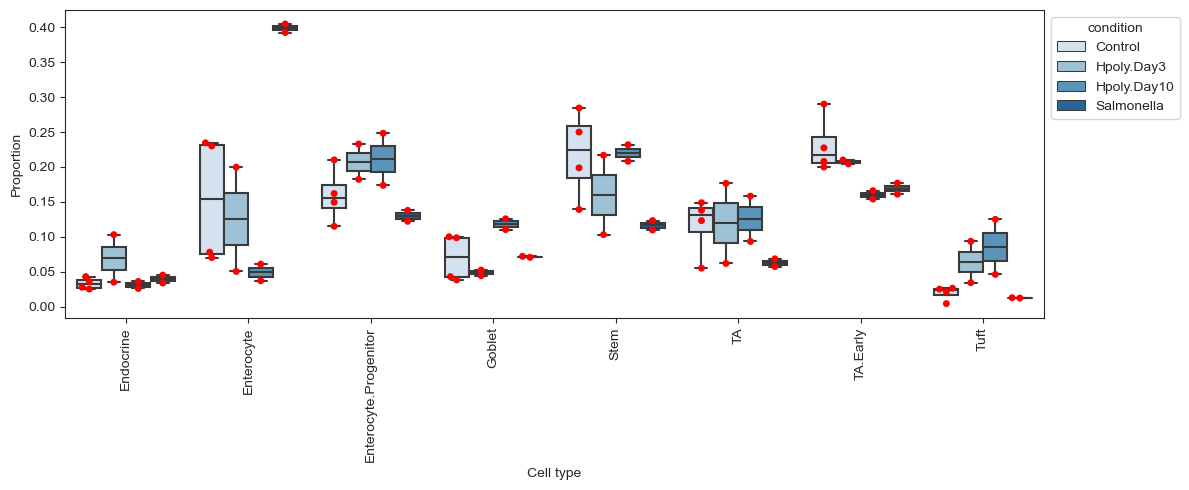

In [13]:
scc_viz.boxplots(scc_df, feature_name="condition", figsize=(12, 5), add_dots=True, args_swarmplot={"palette": ["red"]})
plt.show()

The boxplots highlight some differences in the distributions of the cell types. Clearly noticable is the high proportion of enterocytes for the Salmonella condition. But other cell types such as transit-amplifying (TA) cells also show stark differences in abundance for the Salmonella condition compared to control. Whether any of these differences are statistically significant has to be properly evaluated.

An alternative visualization is a stacked barplot as provided by scCODA. This visualization nicely displays the characteristics of compositional data: If we compare the Control and Salmonella groups, we can see that the proportion of Enterocytes greatly increases in the infected mice. Since the data is proportional, this leads to a decreased share of all other cell types to fulfil the sum-to-one constraint.

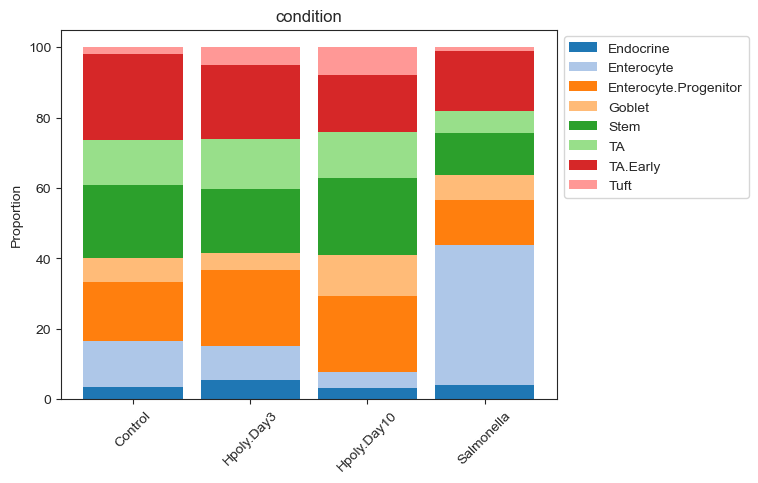

In [14]:
scc_viz.stacked_barplot(scc_df, feature_name="condition")
plt.show()

scCODA requires two major parameters beyond the cell count AnnData object: A formula and a reference cell type. The formula describes the covariates, which are specified using the [R-style](https://www.statsmodels.org/stable/example_formulas.html). In our case we specify the condition as the only covariate. Since it is a discrete covariate with four levels (control and three disease states), this models a comparison of each state with the other samples.
If we wanted to model multiple covariates at once, simply adding them in the formula (i.e. `formula = "covariate_1 + covariate_2"`) is enough.
As mentioned above, scCODA requires a reference cell type to compare against, which is believed to be unchanged by the covariates. scCODA can either automatically select an appropriate cell type as reference, which is a cell type that has nearly constant relative abundance over all samples, or be run with a user specified reference cell type. Here we set Endocrine cells as the reference since visually their abundance seems to be rather constant. An alternative to setting a reference cell type manually is to set the `reference_cell_type` to `"automatic"` which will force scCODA to select a suitable reference cell type itself. If the choice of reference cell type is unclear, we recommend to use this option to get an indicator or even a final selection.

In [15]:
sccoda_mod = scc_ana.CompositionalAnalysis(
        scc_df,
        formula="condition",
        reference_cell_type="Endocrine",
    )
sccoda_res = sccoda_mod.sample_hmc(num_results=20000)

100%|██████████| 20000/20000 [00:59<00:00, 336.48it/s]


MCMC sampling finished. (83.121 sec)
Acceptance rate: 59.5%


The acceptance rate describes the fraction of proposed samples that are accepted after the initial burn-in phase, and can be an ad-hoc indicator for a bad optimization run. In the case of scCODA, the desired acceptance rate is between 0.4 and 0.9. Acceptance rates that are way higher or too low indicate issues with the sampling process.

In [16]:
sccoda_res

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

scCODA selects credible effects based on their inclusion probability. The cutoff between credible and non-credible effects depends on the desired false discovery rate (FDR). A smaller FDR value will produce more conservative results, but might miss some effects, while a larger FDR value selects more effects at the cost of a larger number of false discoveries.
The desired FDR level can be easily set after inference via sim_results.set_fdr(). Per default, the value is 0.05. Since, depending on the dataset, the FDR can have a major influence on the result, we recommend to try out different FDRs up to 0.2 to get the most prominent effects.

In our case, we use less strict FDR of 0.2.

In [17]:
sccoda_res.set_fdr(0.2)

To get the binary classification of compositional changes per cell type we use the `credible_effects` function of scCODA on the result object. Every cell type labeled as "True" is significantly more or less present. The fold-changes describe whether the cell type is more or less present. Hence, we will plot them alongside the binary classification below.

In [18]:
sccoda_res.credible_effects()

Covariate                 Cell Type            
condition[T.Hpoly.Day10]  Endocrine                False
                          Enterocyte                True
                          Enterocyte.Progenitor    False
                          Goblet                   False
                          Stem                     False
                          TA                       False
                          TA.Early                 False
                          Tuft                      True
condition[T.Hpoly.Day3]   Endocrine                False
                          Enterocyte               False
                          Enterocyte.Progenitor    False
                          Goblet                   False
                          Stem                     False
                          TA                       False
                          TA.Early                 False
                          Tuft                     False
condition[T.Salmonella]   Endocrine     

To be able to easily plot the fold changes together with the binary classification, we create intermediate objects for all conditions.
1. Pandas DataFrames which only store the cell types and whether they had significant compositional changes
2. Pandas DataFrames which have the cell types as indices and the scCODA learned metrics as values.

In [19]:
credible_effects_salmonella = sccoda_res.credible_effects()["condition[T.Salmonella]"]
credible_effects_hpoly_day3 = sccoda_res.credible_effects()["condition[T.Hpoly.Day3]"]
credible_effects_hpoly_day10 = sccoda_res.credible_effects()["condition[T.Hpoly.Day10]"]
print(credible_effects_salmonella)

Cell Type
Endocrine                False
Enterocyte                True
Enterocyte.Progenitor    False
Goblet                   False
Stem                     False
TA                       False
TA.Early                 False
Tuft                     False
Name: Final Parameter, dtype: bool


In [20]:
salmonella_effect = sccoda_res.effect_df.loc["condition[T.Salmonella]"]
hpoly_effect_3 = sccoda_res.effect_df.loc["condition[T.Hpoly.Day3]"]
hpoly_effected_10 = sccoda_res.effect_df.loc["condition[T.Hpoly.Day10]"]

salmonella_effect

,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Cell Type,,,,,,,
Endocrine,0.000000,0.000,0.000,0.000,0.000000,32.283111,-0.525977
Enterocyte,1.535917,1.055,2.106,0.283,1.000000,383.163406,1.689883
Enterocyte.Progenitor,0.000000,-0.528,0.527,0.136,0.252400,125.655521,-0.525977
Goblet,0.000000,-0.296,1.100,0.281,0.424267,53.439181,-0.525977
Stem,0.000000,-0.805,0.252,0.170,0.293467,135.036377,-0.525977
TA,0.000000,-0.853,0.351,0.209,0.351533,78.849755,-0.525977
TA.Early,0.000000,-0.353,0.650,0.161,0.303067,152.863322,-0.525977
Tuft,0.000000,-1.348,0.644,0.378,0.445333,22.909329,-0.525977


Inspired by plots from "High-resolution single-cell atlas reveals diversity and plasticity of tissue-resident neutrophils in non-small cell lung cancer"{cite}`Salcher2022`, we can now easily filter by the cell types that had credible changes and show their log fold changes. This is easily done with the plotting library [Altair](https://altair-viz.github.io/).

In [21]:
(
    alt.Chart(
        salmonella_effect
        .loc[credible_effects_salmonella]
        .reset_index(),
        title="Salmonella",
    )
    .mark_bar()
    .encode(
        x=alt.X("Cell Type", sort="y"),
        y="log2-fold change",
        color=alt.Color("Cell Type"),
    )
    | alt.Chart(
        hpoly_effect_3
        .loc[credible_effects_hpoly_day3]
        .reset_index(),
        title="Heligmosomoides polygyrus day 3",
    )
    .mark_bar()
    .encode(
        x=alt.X("Cell Type", sort="y"),
        y="log2-fold change",
        color=alt.Color("Cell Type"),
    )
    | alt.Chart(
        hpoly_effected_10
        .loc[credible_effects_hpoly_day10]
        .reset_index(),
        title="Heligmosomoides polygyrus day 10",
    )
    .mark_bar()
    .encode(
        x=alt.X("Cell Type", sort="y"),
        y="log2-fold change",
        color=alt.Color("Cell Type"),
    )
).resolve_scale(y="shared", color="shared")

alt.HConcatChart(...)

The plots nicely show the significant and credible effects of conditions on the cell types. These effects largely agree with the findings in the Haber paper, who used a non-compositional Poisson regression model their findings:

1. "After Salmonella infection, the frequency of mature enterocytes increased substantially."{cite}`Haber2017`
2. "Heligmosomoides polygyrus caused an increase in the abundance of goblet and tuft cells."{cite}`Haber2017`

Readers familiar with the original publication may wonder why the model used by Haber et al. found more significant effects than scCODA, for example a decrease in Stem and Transit-Amplifying cells in the case of Salmonella infection{cite}`Haber2017`. To explain this discrepancy, remember that cell count data is compositional and therefore an increase in the relative abundance of one cell type will lead to a decrease in the relative abundance of all other cell types.
Due to the stark increase of Enterocytes in the small intestinal epithelium of Salmonella-infected mice, all other cell types appear to decrease, even though this shift is only caused by the compositional properties of the data. While the original (univariate) Poisson regression model will pick up these likely false positive effects, scCODA is able to account for the compositionality of the data and therefore does not fall into this trap.

## With labeled clusters and hierarchical structure

In addition to the abundance of each cell type, a typical single-cell dataset also contains information about the similarity of the different cells in the form of a tree-based hierarchical ordering. These hierarchies can either be determined automatically via clustering of the gene expression (which is usually done to discover the clusters of cells that belong to the same cell type), or through biologically informed hierarchies like cell lineages.
[tascCODA](https://tasccoda.readthedocs.io/en/latest/) is an extension of scCODA that integrates hierarchical information and experimental covariate data into the generative modeling of compositional count data{cite}`Ostner2021`. This is especially beneficial for cell atlassing efforts with increased resolution.

At its core, it uses almost the same Dirichlet-Multinomial setup as scCODA, but extends the model, such that effects on sets of cell types, which are defined as internal nodes in the tree structure.

In [27]:
import toytree as tt
import tasccoda.tree_ana as ta
import tasccoda.tree_utils as tu

import schist

To use tascCODA, we first have to define a hierarchical ordering of the cell types. One possible way of hierarchical clustering wis to use the eight cell types and order them by their similarity (pearson correlation) in the PCA representation with `sc.tl.dendrogram`.
Since this structure is very simple in our data and will therefore not give us many new insights, we want to have a more complex clustering. One recent method to get such clusters, is the [schist](https://github.com/dawe/schist) package {cite}`Morelli2021`, which uses a nested stochastic block model that clusters the cell population at different resolution levels. Running the method with standard settings takes some time (~15 minutes on our data), and gives us an assignment of each cell to a hierarchical clustering in `adata.obs`.
First, we need to define a distance measure between the cells through a PCA embedding:

In [23]:
# use logcounts to calculate PCA and neighbors
adata.layers['counts'] = adata.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers['counts']).copy()
adata.X = adata.layers['logcounts'].copy()
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

# Calculate UMAP for visualization purposes
sc.tl.umap(adata)


         Falling back to preprocessing with `sc.pp.pca` and default params.


Then, we can run schist on the anndata object, which results in a clustering that is defined through a set of columns "nsbm_level_{i}" in `adata.obs`:

In [24]:
schist.inference.nested_model(adata, samples=100, random_seed=1234)
adata.obs

,batch,barcode,condition,cell_label,nsbm_level_0,nsbm_level_1,nsbm_level_2,nsbm_level_3,nsbm_level_4,nsbm_level_5,nsbm_level_6
index,,,,,,,,,,,
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor,B1,AAACATACCACAAC,Control,Enterocyte.Progenitor,0,25,4,2,0,0,0
B1_AAACGCACGAGGAC_Control_Stem,B1,AAACGCACGAGGAC,Control,Stem,1,1,1,1,1,0,0
B1_AAACGCACTAGCCA_Control_Stem,B1,AAACGCACTAGCCA,Control,Stem,2,2,2,1,1,0,0
B1_AAACGCACTGTCCC_Control_Stem,B1,AAACGCACTGTCCC,Control,Stem,3,8,1,1,1,0,0
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor,B1,AAACTTGACCACCT,Control,Enterocyte.Progenitor,187,4,4,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
B10_TTTCACGACAAGCT_Salmonella_TA,B10,TTTCACGACAAGCT,Salmonella,TA,6,3,1,1,1,0,0
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte,B10,TTTCAGTGAGGCGA,Salmonella,Enterocyte,155,17,11,1,1,0,0
B10_TTTCAGTGCGACAT_Salmonella_Stem,B10,TTTCAGTGCGACAT,Salmonella,Stem,110,1,1,1,1,0,0


A UMAP plot nicely shows how the clustering from schist (here on levels 1 and 2) is connected to the cell type assignments. The representation on level 1 of the hierarchy is hereby a strict refinement of the level above, i.e. each cluster from level 2 is split into multiple smaller clusters:

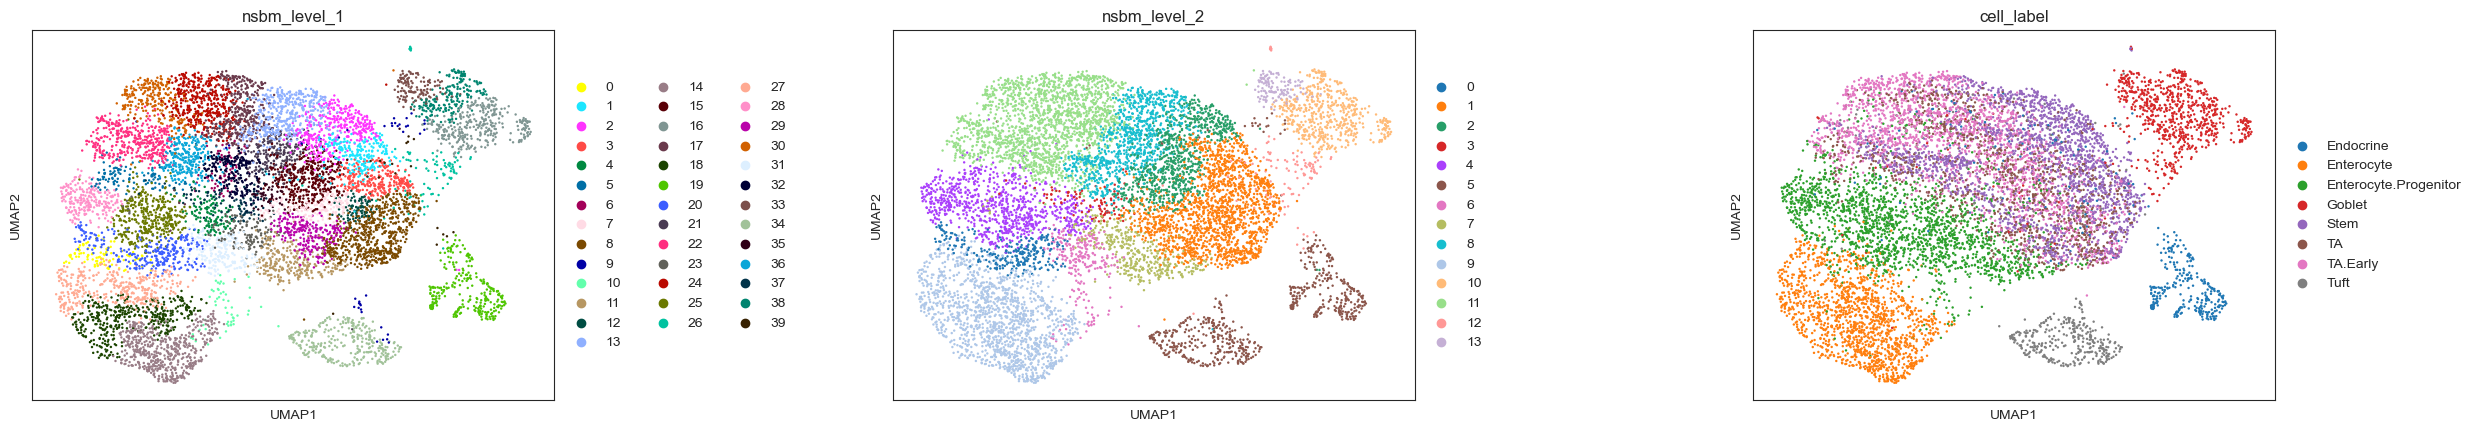

In [89]:
sc.pl.umap(adata, color=["nsbm_level_1", "nsbm_level_2", "cell_label"], ncols=3, wspace=0.5)

To get a data structure that tascCODA can use, we must create a new anndata object in the same way as for scCODA, but with the clustering defined by schist instead of the cell types from before.


In [85]:
# Group data
tasccoda_frac = (
    adata.obs.loc[
        lambda x: x["condition"].isin(["Control", "Salmonella", 'Hpoly.Day3', 'Hpoly.Day10'])
    ]
    .groupby(["condition", "batch"])
    .apply(lambda x: x.value_counts("nsbm_level_1", normalize=False))
    .reset_index(name="n_cells")
    .assign(condition=lambda x: x["condition"].astype(str))
)

# Pivot data
tasccoda_pivot = (
    tasccoda_frac.pivot(
        index=["batch", "condition"],
        columns="nsbm_level_1",
        values="n_cells",
    )
    .reset_index()
)

tasccoda_data = scc_dat.from_pandas(
    tasccoda_pivot, covariate_columns=["batch", "condition"]
)
tasccoda_data

AnnData object with n_obs × n_vars = 10 × 40
    obs: 'batch', 'condition'

Additionally, we need to convert our tree representation into a [toytree](https://toytree.readthedocs.io/) structure and save it as `tasccoda_data.uns["phylo_tree"]`. The [tascCODA tutorial](https://tasccoda.readthedocs.io/en/latest/tascCODA_tutorial.html) shows a way to create a toytree object from a DataFrame via a [Newick string](https://en.wikipedia.org/wiki/Newick_format), which we replicate here. To get some clusters that are not too small, we cut the tree before the last level by leaving out `"nsbm_level_0"`. Note that not only the leaves of the trees have names (0-39), but also the internal nodes are named now with labels 40-61:

In [91]:
# Convert cluster names to strings
n_levels=6
for i in range(n_levels):
    adata.obs[f"nsbm_level_{i}"] = adata.obs[f"nsbm_level_{i}"].astype(str)

# Generate tree
newick = tu.df2newick(adata.obs.reset_index(), levels=["nsbm_level_5", "nsbm_level_4", "nsbm_level_3", "nsbm_level_2", "nsbm_level_1"])
tree = tt.tree(newick)

tasccoda_data.uns["phylo_tree"] = tree
tasccoda_data.var.index = tasccoda_data.var.index.astype(str)
# draw tree
tree.draw(tip_labels_align=True, node_sizes=10, node_labels='name', width=600, node_markers="r2x1.25", node_colors="lightblue", layout="d")

# Replace NaN values with 0 counts
tasccoda_data.X = np.nan_to_num(tasccoda_data.X)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="600.0px" height="260.0px" viewBox="0 0 600.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t24509b74a31b446a8b656b313849b311"> 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 36 22 24 30 17 6 29 12 3 7 8 1 32 13 21 35 15 2 27 18 14 0 31 10 20 28 5 4 25 23 11 37 9 19 34 39 26 38 16 33

The model setup and execution in tascCODA works analogous to scCODA, and also the free parameters for the reference and the formula are the same. Additionally, we can adjust the tree aggregation and model selection via the parameters `phi` and `lambda_1` in the `pen_args` argument (see {cite}Ostner2021 for more information). Here, we use an unbiased setting `phi=0` and a model selection that is slightly less strict than the default with `lambda_1=1.7`. We use cluster 19 as our reference, since it is almost identical to the set of Endocrine cells.

In [114]:
tasccoda_mod= ta.CompositionalAnalysisTree(
            tasccoda_data,
            reference_cell_type="19",
            formula="condition",
            pen_args={"phi": 0, "lambda_1": 1.7}
        )

tasccoda_res = tasccoda_mod.sample_hmc_da()

Zero counts encountered in data! Added a pseudocount of 0.5.


100%|██████████| 20000/20000 [03:10<00:00, 105.00it/s]


MCMC sampling finished. (226.605 sec)
Acceptance rate: 88.5%


Again, the acceptance probability is right around the desired value of 0.85 for tascCODA, indicating no apparent problems with the optimization.

The result from tascCODA should first and foremost be interpreted as effects on the nodes of the tree. A nonzero parameter on a node means that the aggregated count of all cell types under that node changes significantly.
We can easily visualize this in a tree plot for each of the three disease states. Blue circles indicate an increase, red circles a decrease:

In [115]:
covariate = "condition[T.Salmonella]_node"
tasccoda_res.draw_tree_effects(tree, covariate)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="260.0px" height="720.0px" viewBox="0 0 260.0 720.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te9a1ff71c19740c397f2ee3f9b83cfe4"> 36 22 24 30 17 6 29 12 3 7 8 1 32 13 21 35 15 2 33 9 19 34 39 26 38 16 20 27 18 14 0 31 10 37 28 5 4 25 23 11

In [116]:
covariate = "condition[T.Hpoly.Day3]_node"
tasccoda_res.draw_tree_effects(tree, covariate)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="260.0px" height="720.0px" viewBox="0 0 260.0 720.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tdd99ad73c2714095a4838f114ba9265f"> 36 22 24 30 17 6 29 12 3 7 8 1 32 13 21 35 15 2 33 9 19 34 39 26 38 16 20 27 18 14 0 31 10 37 28 5 4 25 23 11

In [117]:
covariate = "condition[T.Hpoly.Day10]_node"
tasccoda_res.draw_tree_effects(tree, covariate)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="260.0px" height="720.0px" viewBox="0 0 260.0 720.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t684f3193d0704b009a437781d9a097d6"> 36 22 24 30 17 6 29 12 3 7 8 1 32 13 21 35 15 2 33 9 19 34 39 26 38 16 20 27 18 14 0 31 10 37 28 5 4 25 23 11

Alternatively, effects on internal nodes can also be translated through the tree onto the cell type level, allowing for a calculation of log-fold changes like in scCODA.
To visualize the log-fold changes of the cell types, we do the same plots as for scCODA, inspired by "High-resolution single-cell atlas reveals diversity and plasticity of tissue-resident neutrophils in non-small cell lung cancer"{cite}`Salcher2022`.

In [118]:

salmonella_effect = tasccoda_res.effect_df.loc["condition[T.Salmonella]"]
hpoly_effect_3 = tasccoda_res.effect_df.loc["condition[T.Hpoly.Day3]"]
hpoly_effect_10 = tasccoda_res.effect_df.loc["condition[T.Hpoly.Day10]"]

credible_effects_salmonella = salmonella_effect["Effect"] != 0
credible_effects_hpoly_day3 = hpoly_effect_3["Effect"] != 0
credible_effects_hpoly_day10 = hpoly_effect_10["Effect"] != 0
(
    alt.Chart(
        salmonella_effect
        .loc[credible_effects_salmonella]
        .reset_index(),
        title="Salmonella",
    )
    .mark_bar()
    .encode(
        x=alt.X("Cell Type", sort="y"),
        y="log2-fold change",
        color=alt.Color("Cell Type"),
    )
    | alt.Chart(
        hpoly_effect_3
        .loc[credible_effects_hpoly_day3]
        .reset_index(),
        title="Heligmosomoides polygyrus day 3",
    )
    .mark_bar()
    .encode(
        x=alt.X("Cell Type", sort="y"),
        y="log2-fold change",
        color=alt.Color("Cell Type"),
    )
    | alt.Chart(
        hpoly_effect_10
        .loc[credible_effects_hpoly_day10]
        .reset_index(),
        title="Heligmosomoides polygyrus day 10",
    )
    .mark_bar()
    .encode(
        x=alt.X("Cell Type", sort="y"),
        y="log2-fold change",
        color=alt.Color("Cell Type"),
    )
).resolve_scale(y="shared", color="shared")

alt.HConcatChart(...)

Another insightful representation can be gained by plotting the effect sizes for each condition on the UMAP embedding, and comparing it to the cell type assignments:

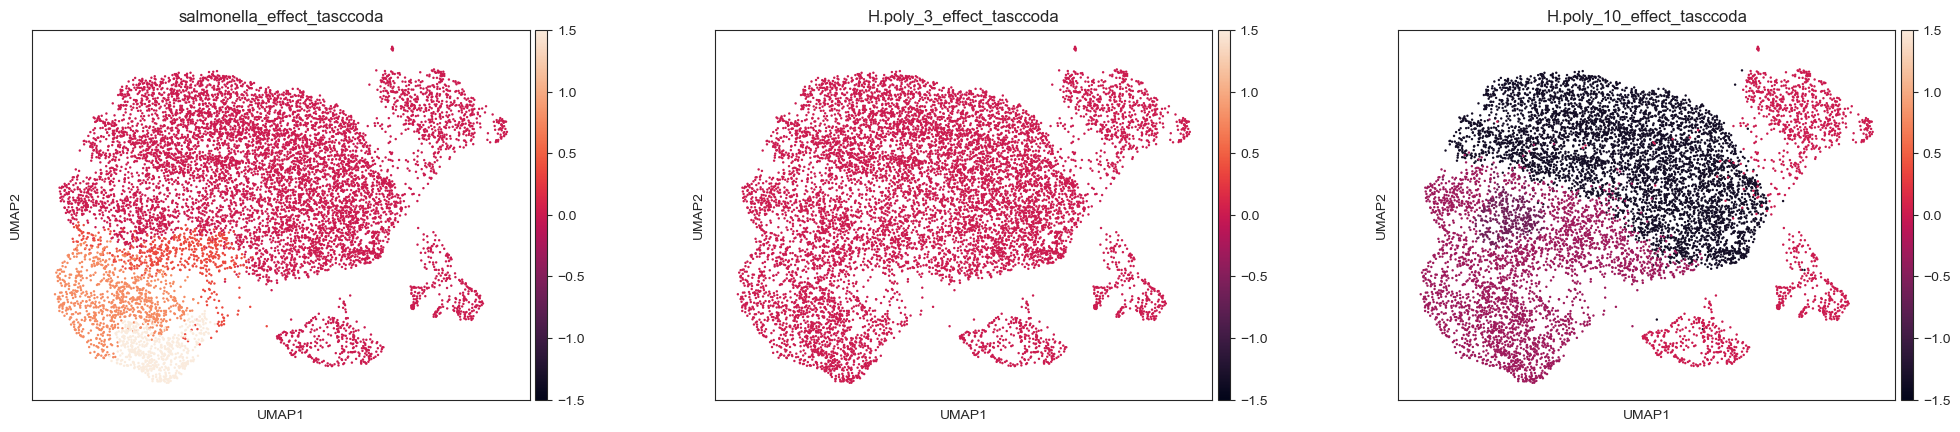

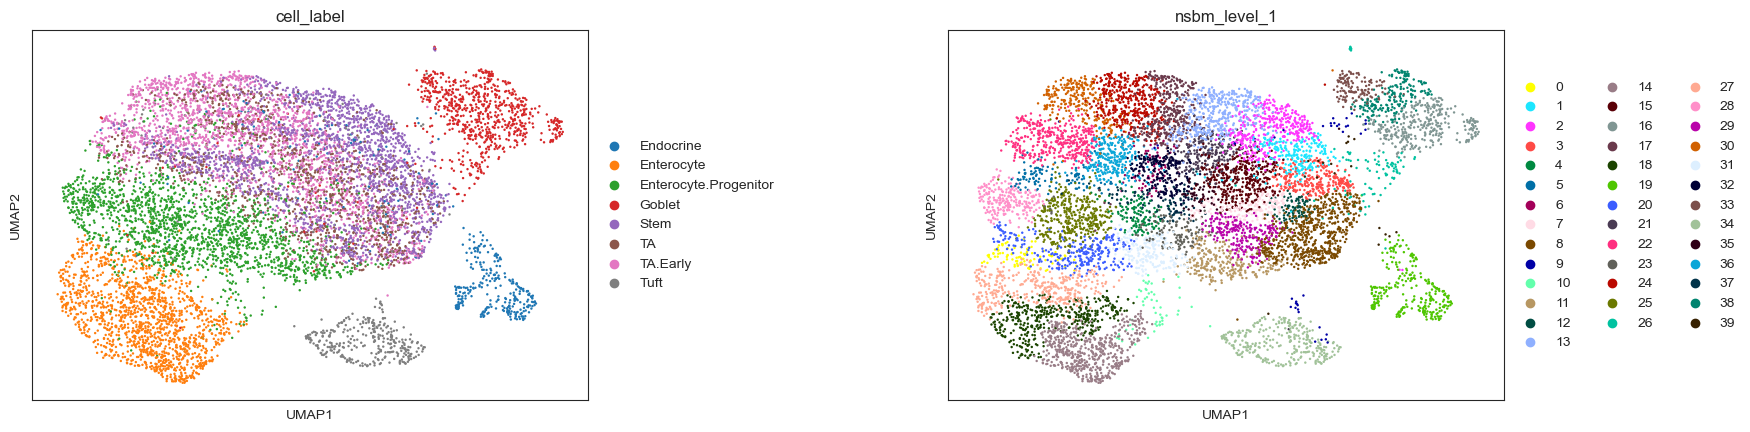

In [129]:
adata.obs["salmonella_effect_tasccoda"] = [tasccoda_res.effect_df.loc[("condition[T.Salmonella]", c), "Effect"] for c in adata.obs["nsbm_level_1"]]
adata.obs["H.poly_3_effect_tasccoda"] = [tasccoda_res.effect_df.loc[("condition[T.Hpoly.Day3]", c), "Effect"] for c in adata.obs["nsbm_level_1"]]
adata.obs["H.poly_10_effect_tasccoda"] = [tasccoda_res.effect_df.loc[("condition[T.Hpoly.Day10]", c), "Effect"] for c in adata.obs["nsbm_level_1"]]

sc.pl.umap(adata, color=["salmonella_effect_tasccoda", "H.poly_3_effect_tasccoda", "H.poly_10_effect_tasccoda"], ncols=3, wspace=0.25, vcenter=0, vmax=1.5, vmin=-1.5)
sc.pl.umap(adata, color=["cell_label", "nsbm_level_1"], ncols=2, wspace=0.5)

The results are very similar to scCODA's findings:
- For the Salmonella infection, we get an aggregated increase in clusters that approximately represent Enterocytes in the cell type clustering. This increase is even stronger for cluster 14, as indicated by the additional positive effect on the leaf level
- For the Heligmosomoides polygyrus infection, we get no credible changes after 3 days. After 10 days, we pick up decreases in clusters that contain Stem- and transit-amplifying cells, as well as a less strong decrease of Enterocytes and Enterocyte progenitors, which was also picked up by scCODA.

## Without labeled clusters

It is not always possible to obtain precise labeled clusters such as cell-type definitions, especially when the clustering boundaries are deceptive, such as during developmental processes. In such cases, determining compositional changes based on known annotations may not be appropriate. DA-seq uses a low dimensional transformation such as PCA to calculate a k-nearest neighbor graph (KNN) which is used to compute a density in the form of score vectors for each cell to group these cells into differentially abundant subpopulations{cite}`Zhao2021`. MILO assigns cells to partially overlapping neighborhoods on a KNN graph to perform differential abundance (DA) testing{cite}`Dann2022`. Both KNN-based methods are sensitive to a loss of information if the conditions of interest and confounders, defined by technical or experimental sources of variation, are strongly correlated. A fundamental limitation of KNN-based methods is that cells in a neighborhood may not necessarily represent a specific, unique biological subpopulation, because a cellular state may span over multiple neighborhoods. Reducing k for the KNN graph or constructing a graph on cells from a particular lineage of interest mitigates this issue{cite}`Dann2022`. Generally, if large differences are apparent in large clusters by visualization or a specific cell-type is of interest, KNN based methods might be ill-suited and a more direct analysis with cell-type aware methods might be a more promising option. Alternatively, quantification of perturbation effects on the level of single-cells is possible with MELD, which calculates a relative likelihood estimate of observing each cell in every condition using graph signaling{cite}`Burkhardt2021`. The determined likelihood estimate can then be used to identify cell populations that were specifically affected by a perturbation.

We will now apply MILO to the Haber dataset to try to find over- or underrepresented neighborhoods.

MILO is available as [miloR](https://github.com/MarioniLab/miloR) for R users and [milopy](https://github.com/emdann/milopy) for Python users in the scverse ecosystem. In the following demonstrate we will use milopy which is easiest to use with our AnnData object due to its scverse compatibility. Be aware that milopy in its current state also requires a working [edgeR](https://bioconductor.org/packages/release/bioc/html/edgeR.html) installation.

First, we import milopy.

In [15]:
import milopy
import milopy.core as milo

ModuleNotFoundError: No module named 'milopy'

TODO: REASONING WHY PCA AND NEIGHBORS FROM LOG COUNTS

In [15]:
# use logcounts to calculate PCA and neighbors
adata.layers['counts'] = adata.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers['counts']).copy()
adata.X = adata.layers['logcounts'].copy()

TODO: https://github.com/emdann/milopy/blob/master/notebooks/milopy_example.ipynb USES THE SAME K ACROSS NEIGHBORS AND MILOPY. GUESS WE SHOULD ALSO DO THIS?
EXPLAIN WHAT WE ARE DOING HERE BRIEFLY. CALCULATING BLA AND VISUALZING BLUB. ALSO EXPLAIN THE BATCH EFFECT ISSUE THAT YOU HAD EARLIER AND HOW TO MITIGATE IT. DO WE NEED SCVI CORRECTION HERE?

TODO: NO PCA BEFORE RUNNING NEIGHBORS WHEN USING MILO? 

In [16]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [17]:
sc.tl.umap(adata)

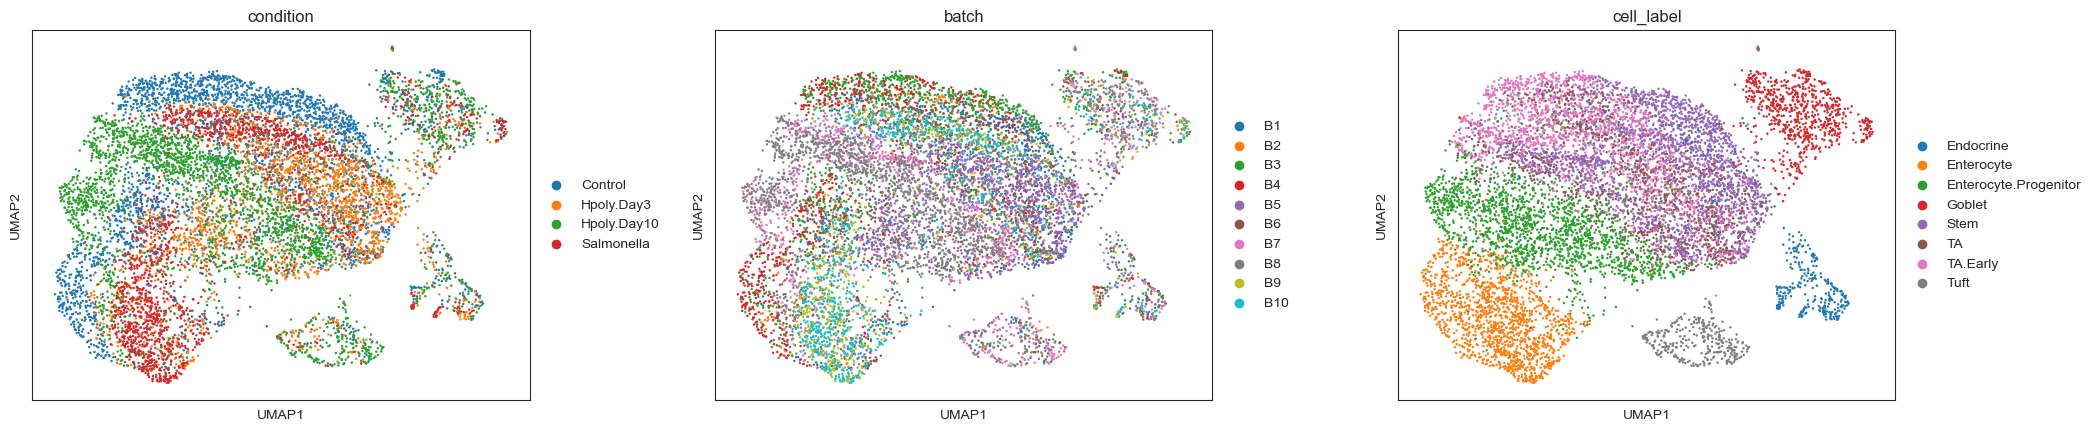

In [18]:
sc.pl.umap(adata, color=['condition', 'batch', 'cell_label'], ncols=3, wspace=0.25)

TODO: ADD COMMENT ON BATCH EFFECT CORRECTION. REQUIRED ALREADY?

MILO is a KNN-based model to test for differential abundance and therefore operates on neighborhoods of cells. Hence, we first we need to create these neighborhoods. We note that MILO uses the neighbours from `.uns['neighbors']`. Therefore, ensure that `sc.pp.neighbors` was run on the correct represenation, i.e. an integrated latent space if batch correction was required.

In [24]:
milo.make_nhoods(adata)

In the next step, MILO counts cells belonging to each of the conditions taking into account that cells come from different batches.

In [ ]:
milo.count_nhoods(adata, sample_col="batch")

Finally, MILO uses edgeR's QLF test to test if there are statistically significant differences between the number of cells from each condition in each neighborhood.

In [26]:
milo.DA_nhoods(adata, design="~ condition")

The final DA for each cell is calculated as the mean DA of all neighborhoods that the cell belongs to. We obtain DA results on the single-cell level.

In [27]:
milo_results = adata.uns["nhood_adata"].obs
milo_results

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,B1_AAACGCACTGTCCC_Control_Stem,5.204549,-5.806651,11.970060,3.896253,0.048448,0.137430,0.138942
1,B1_AAAGGCCTCATGAC_Control_TA.Early,8.568722,-4.212310,11.265669,3.572490,0.058801,0.152096,0.154185
2,B1_AACCAGTGTTTCGT_Control_TA,5.801365,-4.768750,11.517511,3.833202,0.050301,0.139089,0.140793
3,B1_AAGTGCACACGTAC_Control_Stem,5.837218,-3.100849,12.017406,1.523388,0.217164,0.382623,0.377106
4,B1_AATAACACGGCAAG_Control_TA,7.075296,-5.093514,11.429176,4.530634,0.033341,0.133048,0.134970
...,...,...,...,...,...,...,...,...
846,B10_TTAACCACGACAGG_Salmonella_Enterocyte,5.903394,5.664716,11.307082,8.069511,0.004519,0.095743,0.080842
847,B10_TTACGACTGCAAGG_Salmonella_Enterocyte,5.875281,5.739043,11.382824,7.787859,0.005279,0.095743,0.080842
848,B10_TTATCCGATCCTAT_Salmonella_TA.Early,8.265007,3.444163,11.362900,3.642756,0.056370,0.148977,0.151066
849,B10_TTCACAACGGATCT_Salmonella_Goblet,10.840036,1.935549,11.162940,1.154943,0.282568,0.456176,0.449742


TODO: SO YEAH WHAT DO ALL OF THOSE VALUES MEAN? ESPECIALLY SPATIALFDR NEEDS A COMMENT.

We can also visualize the DA results on a UMAP to assess which cell types may be most affected by the disease.

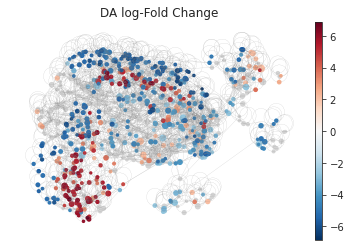

In [28]:
milopy.utils.build_nhood_graph(adata)
milopy.plot.plot_nhood_graph(adata, alpha=0.5, min_size=5, plot_edges=True)

TODO: WHAT DO I SEE? WHAT IS THE EFFECT OF THOSE PARAMETERS?

In case there are different numbers of cells for each of the conditions, we recommend to look at neighborhood MA plot to see if data is distributed around 0. For more details, please read: (https://github.com/MarioniLab/miloR/issues/208)

In [29]:
def plot_nhood_MA(adata, alpha=0.05, mean=0):
    df = adata.uns["nhood_adata"].obs
    # max_lfc = max(abs(df['logFC']))
    # max_eps = max_lfc * 0.1
    emp_null = df[df['SpatialFDR'] >= alpha]['logFC'].mean()
    # min_x = min(df['logCPM'])
    # minx_eps = min_x * 0.01
    # max_x = max(df['logCPM'])
    # maxx_eps = max_x * 0.01 

    df['Sig'] = df['SpatialFDR'] < alpha
    
    fig, ax = plt.subplots()
    sns.scatterplot(data=df, x="logCPM", y="logFC", hue='Sig', ax=ax)
    ax.axhline(y=mean, color='grey', linewidth=1)
    ax.axhline(y=emp_null, color='purple', linewidth=1)
    plt.show()

TODO: SHOULD WE REALLY CREATE A FUNCTION FOR THIS? WE ARE ONLY REALLY USING IT ONCE RIGHT? EXPLAIN THE PARAMETERS

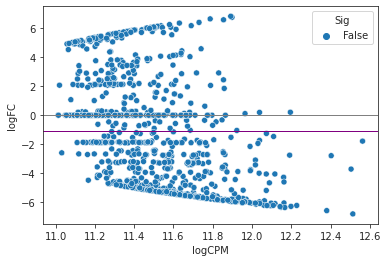

In [30]:
plot_nhood_MA(adata)

TODO: WHAT DOES THE PLOT SHOW? REFER TO COMMENTS IN https://github.com/MarioniLab/miloR/issues/208 AND EXPLAIN WHAT DO IF YOU SEE WHATEVER.

WE ONLY HAVE ONE CLASS. WHY?

TODO: ADD CONCLUSION HERE: WHAT IS DIFFERENT FROM CELL TYPE BASED? WHAT TO USE HERE? ETC

## Key Takeaways

1. If the primary interest lies in compositional changes among known cell-types or states, use scCODA or tascCODA to statistically evaluate changes in abundance.
2. KNN based methods like DA-Seq or MILO should be used if the data does not cluster distinctly, such as during developmental processes. Using MELD might be advisable if the experimental design suggests that KNN neighborhoods are unlikely to capture the perturbation source.

## Quiz

1. It is tricky to deduce compositional changes visually. Why?
2. Why is it necessary to interpret cell type abundances as proportions instead of absolute counts? What are the dangers of not doing so?
3. In which cases should tools that use cluster information, such as cell types be used, and in which cases tools that do not use cluster information?